In [1]:
import vaex
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = vaex.open("data/trips/trips_prepared.hdf5")

In [3]:
df.info()

column,type,unit,description,expression
Taxi ID_encoded,int64,,,
Company_encoded,int64,,,
ts_start,datetime64[us],,,
start_day,datetime64[ns],,,
start_weekday,int64,,,
start_month,int64,,,
Trip Seconds,float64,,,
Trip Miles,float64,,,
Fare,float64,,,
Tips,float64,,,


In [4]:
df_weekday = df[df.start_weekday.isin([0, 1, 2, 3, 4])]
df_weekend = df[df.start_weekday.isin([5, 6])]

In [5]:
# Calculate the average trips per hour for weekdays and weekends
average_trips_weekday = df_weekday.groupby(df_weekday.start_1_hour).agg({'Trip Total': 'mean'})['Trip Total'].values
average_trips_weekend = df_weekend.groupby(df_weekend.start_1_hour).agg({'Trip Total': 'mean'})['Trip Total'].values


In [6]:
angles = np.linspace(0, 2 * np.pi, num=24, endpoint=False)

#vaex to numpy array
average_trips_weekday = average_trips_weekday
average_trips_weekend = average_trips_weekend


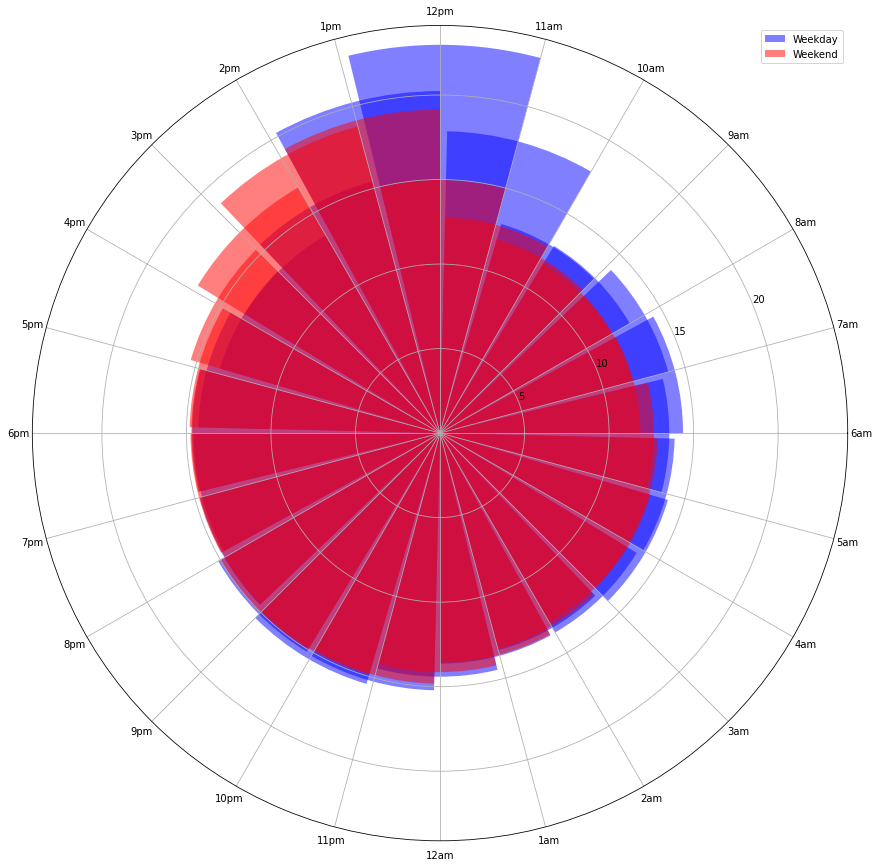

In [7]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, polar=True)

#shifted_angles = np.roll(angles, -6)

# Plot average trips for weekdays in blue
ax.bar(angles, average_trips_weekday, width=0.5, align='edge', label='Weekday', color='blue', alpha=0.5)


# Plot average trips for weekends in red
ax.bar(angles, average_trips_weekend, width=0.5, align='edge', label='Weekend', color='red', alpha=0.5)

ax.set_xticks(angles)
ax.set_xticklabels(['6am', '7am', '8am', '9am', '10am', '11am', '12pm', '1pm',
                    '2pm', '3pm', '4pm', '5pm', '6pm', '7pm', '8pm', '9pm',
                    '10pm', '11pm', '12am', '1am', '2am', '3am', '4am', '5am'])

ax.legend()
plt.show()


In [8]:
#print(angles.shape)
#print(average_trips_weekday.shape)
#print(average_trips_weekend.shape)


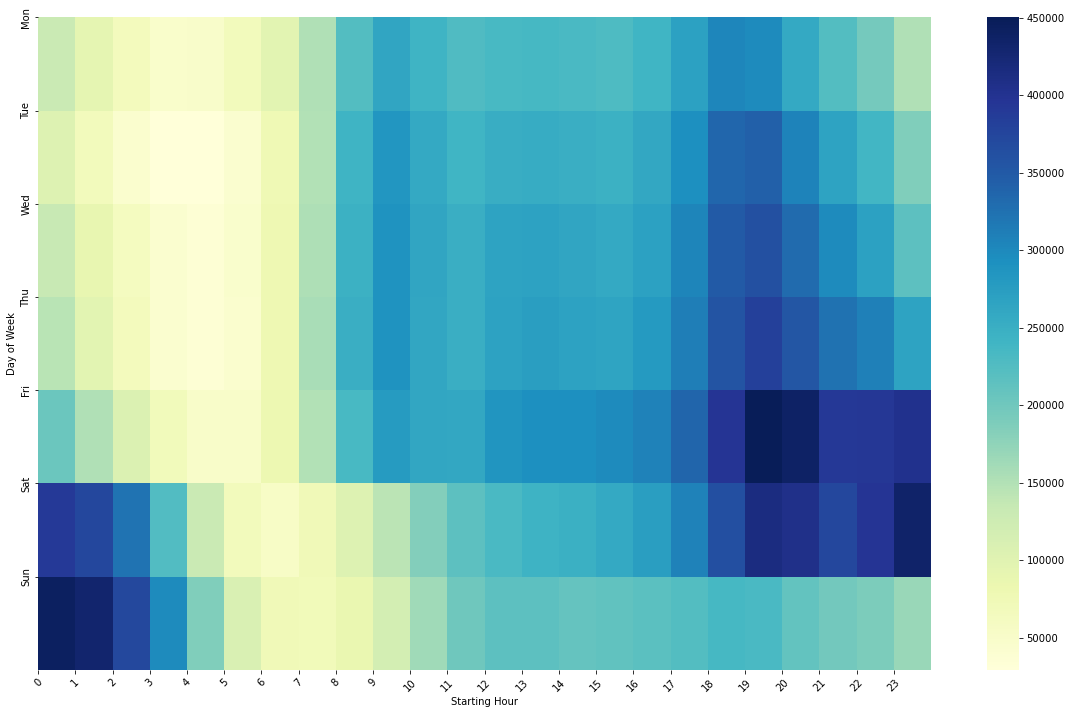

In [9]:
import pandas as pd
import seaborn as sns

# Convert the Vaex DataFrame to a pandas DataFrame
df_pandas = df.to_pandas_df()

# Calculate the count of trips for each combination of start_weekday and start_1_hour
heatmap_data = df_pandas.groupby(['start_weekday', 'start_1_hour']).size().unstack()

# Create a figure and axes for the heatmap
fig, ax = plt.subplots(figsize=(20, 12))

# Create the heatmap using seaborn
sns.heatmap(heatmap_data, cmap='YlGnBu', ax=ax)

# Set the labels for the x and y axes
ax.set_xlabel('Starting Hour')
ax.set_ylabel('Day of Week')

# Set the tick locations and labels for the x and y axes
ax.set_xticks(np.arange(24))
ax.set_xticklabels(np.arange(24))
ax.set_yticks(np.arange(7))
ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Rotate the x-axis tick labels for better readability
plt.xticks(rotation=45)

# Show the heatmap
plt.show()


In [10]:
# Calculate average trip distance
average_distance = df['Trip Miles'].mean().item()

# Calculate minimum trip distance
min_distance = df['Trip Miles'].min().item()

# Calculate maximum trip distance
max_distance = df['Trip Miles'].max().item()

print("Average Trip Distance:", average_distance)
print("Minimum Trip Distance:", min_distance)
print("Maximum Trip Distance:", max_distance)

# Calculate average trip duration
average_duration = df['Trip Seconds'].mean().item()

# Calculate minimum trip duration
min_duration = df['Trip Seconds'].min().item()

# Calculate maximum trip duration
max_duration = df['Trip Seconds'].max().item()

print("Average Trip Duration:", average_duration, "seconds")
print("Minimum Trip Duration:", min_duration, "seconds")
print("Maximum Trip Duration:", max_duration, "seconds")


Average Trip Distance: 2.81333968972651
Minimum Trip Distance: 0.0
Maximum Trip Distance: 1530.4
Average Trip Duration: 738.3478666231151 seconds
Minimum Trip Duration: 0.0 seconds
Maximum Trip Duration: 86340.0 seconds


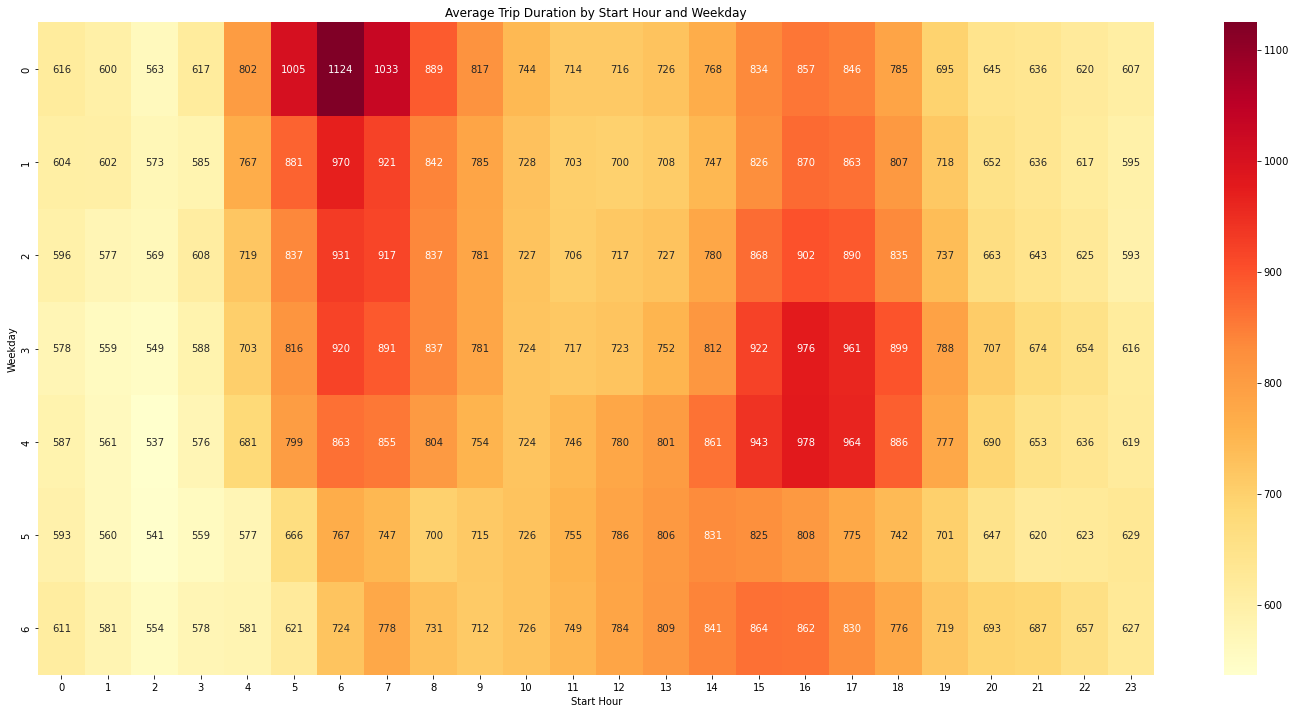

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a pivot table to calculate the average trip duration
pivot_table = df_pandas.pivot_table(values='Trip Seconds', index='start_weekday', columns='start_1_hour', aggfunc='mean')

# Create the heatmap
plt.figure(figsize=(25, 12))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt='.0f', cbar=True)
plt.title('Average Trip Duration by Start Hour and Weekday')
plt.xlabel('Start Hour')
plt.ylabel('Weekday')
plt.show()
